In [1]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from update_deals import deals_df
from Contacts import contacts_df
from Spend import spend_df
from Calls import calls_df

In [2]:
# Загрузка данных из Excel файла
file_path = 'update_deals.xlsx'
deals_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())
print(deals_df.info())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

In [3]:
calls_df.info()
calls_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95874 entries, 0 to 95873
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          95874 non-null  int64         
 1   Call Start Time             95874 non-null  datetime64[ns]
 2   Call Owner Name             95874 non-null  object        
 3   CONTACTID                   95874 non-null  int64         
 4   Call Type                   95874 non-null  object        
 5   Call Duration (in seconds)  95874 non-null  float64       
 6   Call Status                 95874 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.1+ MB


,Id,Call Start Time,Call Owner Name,CONTACTID,Call Type,Call Duration (in seconds),Call Status
41123,5805028000028777204,2024-01-29 14:02:00,Amy Green,5805028000028593828,Outbound,0.0,Unattended Dialled
26454,5805028000019745209,2023-12-05 12:46:00,Paula Underwood,0,Outbound,1213.0,Attended Dialled
74110,5805028000046960025,2024-04-27 14:03:00,Amy Green,5805028000046316382,Outbound,15.0,Attended Dialled
92980,5805028000055343278,2024-06-14 16:08:00,Derek James,5805028000033528294,Outbound,30.0,Attended Dialled
63313,5805028000041344788,2024-04-03 12:20:00,Amy Green,5805028000040531130,Outbound,0.0,Unattended Dialled


### ЗАДАНИЕ ПРОЕКТА:
**Анализ временных рядов:**
- 1. Проанализируйте тенденцию создания сделок с течением времени и их связь с звонками.
- 2. Изучите распределение времени закрытия сделок и продолжительность периода от создания до закрытия

In [4]:
# Добавление столбца с продолжительностью сделки
deals_df['Deal Duration'] = (deals_df['Closing Date'] - deals_df['Created Time']).dt.days

Month
2023-07     636
2023-08    1081
2023-09    1063
2023-10    1596
2023-11    1940
2023-12    1801
2024-01    2209
2024-02    2184
2024-03    2252
2024-04    3082
2024-05    1984
2024-06    1674
Freq: M, dtype: int64


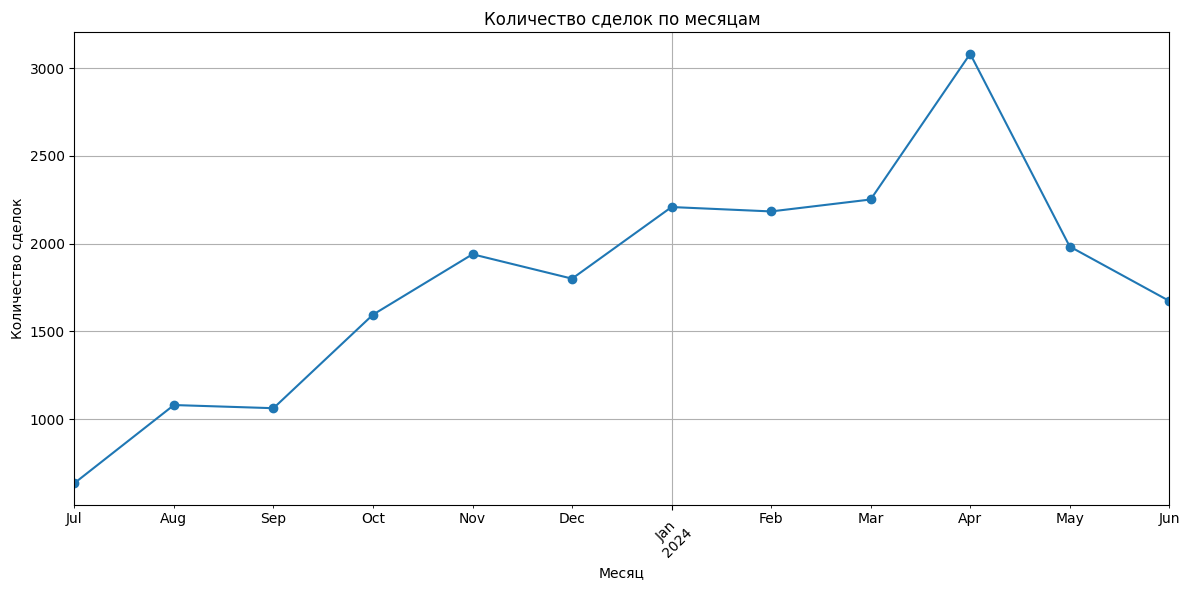

In [5]:
#Анализ тенденций создания сделок
#Для анализа тенденций создания сделок используем временные ряды и визуализацию. 
#Группируем данные по месяцам или годам и построим график.

# Группировка по месяцам и подсчет количества сделок
deals_df['Month'] = deals_df['Created Time'].dt.to_period('M')
monthly_deals = deals_df.groupby('Month').size()
print(monthly_deals)

# Построение графика
plt.figure(figsize=(12, 6))
monthly_deals.plot(kind='line', marker='o')
plt.title('Количество сделок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество сделок')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Анализ графика количества сделок по месяцам:

**Общий тренд**

Наблюдается восходящий тренд в количестве сделок с июля по январь, за исключением небольшого спада в ноябре.
Пик количества сделок приходится на апрель.
После апреля количество сделок значительно уменьшается и достигает минимума в июне.

Сезонность:
    С июля по январь можно наблюдать постепенный рост сделок. Это может быть связано с повышенной активностью клиентов в этот период.
Небольшой спад в ноябре может быть связан с сезонными факторами или временными колебаниями спроса.
Значительный спад в мае и июне указывает на возможное сезонное снижение активности.

Анализ пиков и спадов:
    Январь и апрель выделяются как месяцы с наибольшим количеством сделок. Это может свидетельствовать о специфических маркетинговых 
кампаниях или сезонных предложениях, которые стимулируют продажи.
Спад в мае и июне требует дополнительного анализа. Возможно, в эти месяцы отсутствовали стимулы для покупок, либо были другие 
внешние факторы, влияющие на снижение активности.

**Рекомендации**
    Исследовать причины спада в ноябре и в период с мая по июнь. Возможно, есть возможность улучшить маркетинговые стратегии или 
предложить дополнительные стимулы для клиентов в эти месяцы.
Анализировать успешные стратегии, которые приводят к пикам в январе и апреле, и пытаться адаптировать их для других месяцев.
Рассмотреть возможность введения специальных предложений или акций в менее активные месяцы для выравнивания распределения сделок по годовым периодам.

**Заключение**
    График показывает явную сезонность в количестве сделок, с пиками в январе и апреле и спадами в мае и июне. Для более детального 
анализа следует рассмотреть дополнительные факторы, такие как маркетинговые активности, внешние экономические условия и потребительское поведение.


In [6]:
# Преобразование 'CONTACTID' и 'ContactID' в строки для корректного объединения
deals_df['CONTACTID'] = deals_df['CONTACTID'].astype(str)
calls_df['CONTACTID'] = calls_df['CONTACTID'].astype(str)

# Объединение данных
combined_df = pd.merge(deals_df, calls_df, left_on='CONTACTID', right_on='CONTACTID', how='left')

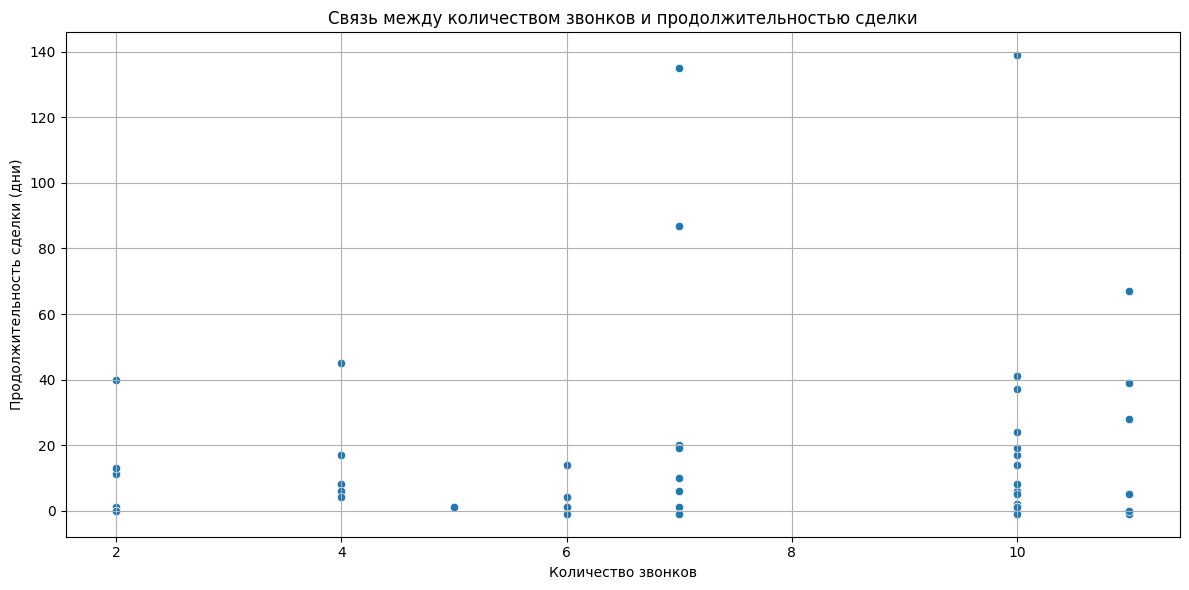

In [7]:
#Анализ количества звонков и их связь с сделками

# Подсчет количества звонков для каждой сделки
call_counts = calls_df.groupby('CONTACTID').size().reset_index(name='Number of Calls')

# Объединение с DataFrame сделок
combined_df = pd.merge(deals_df, call_counts, left_on='CONTACTID', right_on='CONTACTID', how='left')

# Заполнение пропусков
combined_df['Number of Calls'].fillna(0)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Number of Calls', y='Deal Duration', data=combined_df)
plt.title('Связь между количеством звонков и продолжительностью сделки')
plt.xlabel('Количество звонков')
plt.ylabel('Продолжительность сделки (дни)')
plt.grid(True)
plt.tight_layout()
plt.show()

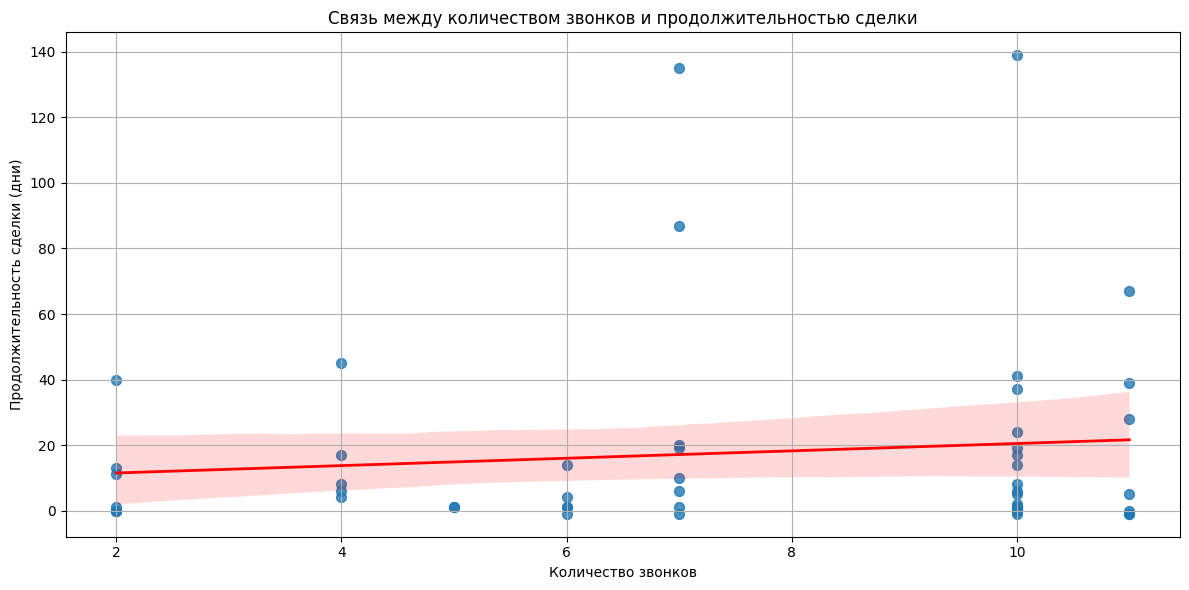

In [8]:
# Создание графика с линейной регрессией
plt.figure(figsize=(12, 6))
sns.regplot(x='Number of Calls', y='Deal Duration', data=combined_df, scatter_kws={'s':50}, line_kws={'color':'red', 'linewidth':2})
plt.title('Связь между количеством звонков и продолжительностью сделки')
plt.xlabel('Количество звонков')
plt.ylabel('Продолжительность сделки (дни)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Анализ графика "Связь между количеством звонков и продолжительностью сделки":

**Общий тренд**:
На графике показана слабая положительная корреляция между количеством звонков и продолжительностью сделки. Это означает, что с увеличением 
количества звонков продолжительность сделки также немного увеличивается.
Однако данная корреляция является достаточно слабой, что видно по небольшой наклонной линии регрессии и широкому доверительному интервалу.

**Распределение данных**:
Большинство данных сконцентрированы в пределах от 1 до 10 звонков и от 0 до 40 дней продолжительности сделки.
Есть несколько выбросов, где количество звонков достигает 10, а продолжительность сделки превышает 100 дней.

**Выбросы**:
На графике видно несколько сделок, которые сильно отличаются от основной массы данных. Это сделки с высоким количеством звонков (более 8) и 
продолжительностью более 100 дней.
Эти выбросы могут быть вызваны особыми случаями, которые требуют дополнительного анализа для понимания их причин.

**Практическое значение**:
Несмотря на слабую положительную корреляцию, можно сделать вывод, что увеличение количества звонков незначительно увеличивает продолжительность сделки.
Это может указывать на то, что более сложные или важные сделки требуют большего количества звонков для их завершения, но это не является строгой 
зависимостью.

**Рекомендации**:
Проанализировать случаи с большим количеством звонков и продолжительностью сделки, чтобы понять, какие факторы влияют на такие результаты.
Возможно, стоит рассмотреть улучшение методов ведения переговоров и повышения эффективности звонков для сокращения продолжительности сделки.

**Заключение**:
График показывает слабую положительную корреляцию между количеством звонков и продолжительностью сделки. Это указывает на то, что увеличение 
количества звонков незначительно увеличивает продолжительность сделки, хотя связь между этими показателями не является сильной. 
Для более детального анализа рекомендуется изучить выбросы и понять, что влияет на продолжительные сделки.

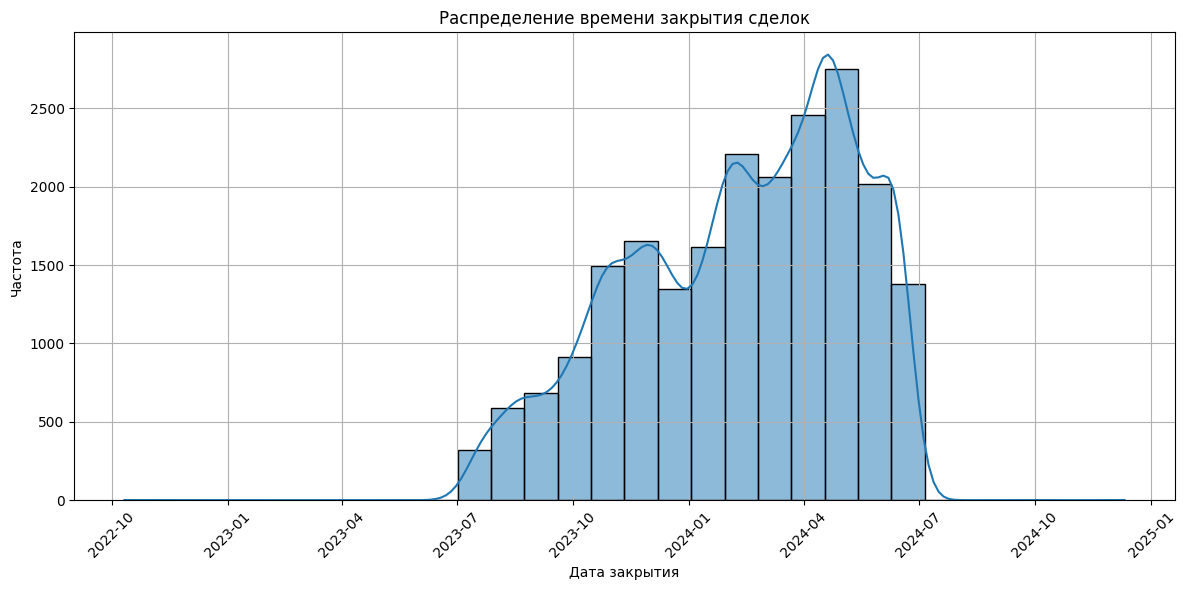

In [9]:
#Изучение распределения времени закрытия сделок

plt.figure(figsize=(12, 6))
sns.histplot(deals_df['Closing Date'].dropna(), bins=30, kde=True)
plt.title('Распределение времени закрытия сделок')
plt.xlabel('Дата закрытия')
plt.ylabel('Частота')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Анализ графика "Распределение времени закрытия сделок"

**Общее распределение**:
Гистограмма показывает распределение количества закрытых сделок по времени с осени 2022 года по лето 2024 года.
Гистограмма накладывается на линию KDE (ядровая плотность), которая показывает сглаженное распределение данных.

**Основные наблюдения**:

В начале периода (осень 2022 года) закрытое количество сделок было низким.
Начиная с конца 2022 года, наблюдается стабильный рост количества закрытых сделок.
Пик количества сделок приходится на период с марта по май 2024 года, после чего количество сделок начинает уменьшаться.

**Всплески и спады**:
Первый заметный рост начинается в конце 2022 года и продолжается до конца 2023 года.
В январе 2024 года наблюдается временный спад, за которым следует резкий рост до апреля 2024 года.
Пик в апреле 2024 года является самым высоким, с более чем 2500 сделок.
После пика в апреле 2024 года наблюдается резкое снижение количества закрытых сделок до лета 2024 года.

**Временные колебания**:

График показывает сезонные колебания, где зимой и весной 2024 года наблюдается более высокая активность по закрытию сделок.
Летом 2024 года наблюдается значительное снижение активности.

**Практическое значение**:

Временные колебания могут быть связаны с сезонными факторами, такими как отпускные периоды, квартальные отчеты или маркетинговые кампании.
Пик активности в апреле 2024 года может быть результатом специальных акций, успешных маркетинговых кампаний или других стимулирующих мероприятий.

**Рекомендации**:
**Анализ сезонности**:
Проанализировать причины сезонных всплесков и спадов, чтобы понять, какие факторы влияют на количество закрытых сделок.
Это может включать в себя анализ маркетинговых кампаний, сезонных акций или внешних факторов (например, экономических условий).

**Усиление в период спада**:
Планировать дополнительные маркетинговые и стимулирующие мероприятия в периоды, когда наблюдается спад активности, чтобы выровнять 
количество закрытых сделок.

**Оптимизация ресурсов**:
В периоды пиковых нагрузок (март-май 2024 года) необходимо обеспечить достаточное количество ресурсов (персонала, времени, финансов) 
для эффективного управления увеличенным количеством сделок.

**Анализ кампаний**:
Провести углубленный анализ маркетинговых кампаний, которые проводились в периоды пиковых активностей, чтобы определить наиболее эффективные 
стратегии и тактики.

**Мониторинг тенденций**:
Постоянно отслеживать и анализировать тенденции закрытия сделок, чтобы оперативно реагировать на изменения и адаптировать стратегии в 
зависимости от текущей ситуации.
Эти шаги помогут оптимизировать процессы и повысить эффективность отдела продаж, ориентируясь на выявленные закономерности и тенденции.

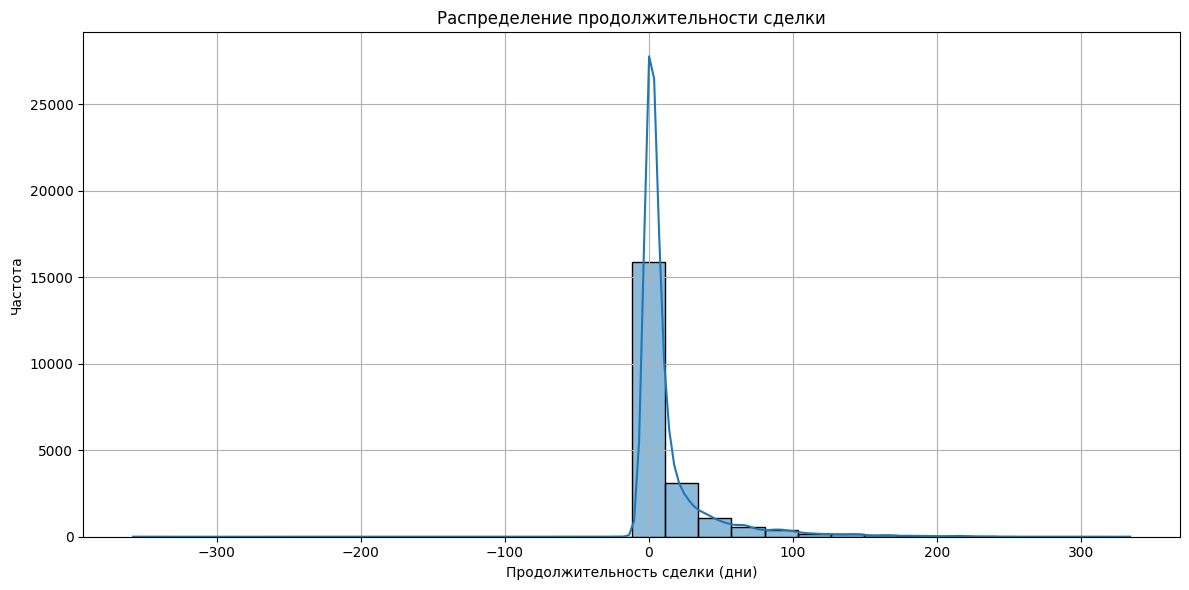

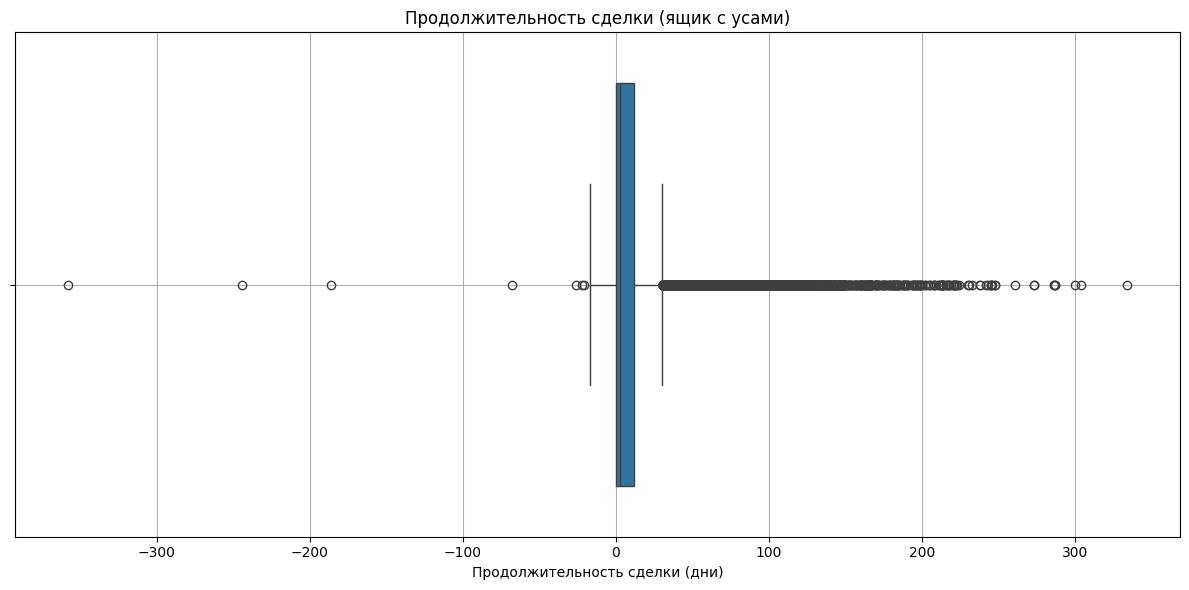

In [10]:
#Продолжительность периода от создания до закрытия

plt.figure(figsize=(12, 6))
sns.histplot(deals_df['Deal Duration'].dropna(), bins=30, kde=True)
plt.title('Распределение продолжительности сделки')
plt.xlabel('Продолжительность сделки (дни)')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

# Ящик с усами
plt.figure(figsize=(12, 6))
sns.boxplot(x='Deal Duration', data=deals_df)
plt.title('Продолжительность сделки (ящик с усами)')
plt.xlabel('Продолжительность сделки (дни)')
plt.grid(True)
plt.tight_layout()
plt.show()

### График - Распределение времени закрытия сделок по часам 
**По данному графику можно сделать несколько выводов**:

**Концентрация сделок в первые часы**:
Основное количество сделок закрывается в первые часы после открытия. Это видно по пику графика в районе 0-1 часов. Это может указывать на то, 
что большинство сделок закрывается практически сразу после их создания.

**Малая активность в остальные часы**:
После первых часов активность резко падает, и количество сделок, закрываемых в последующие часы, существенно ниже. На графике видно, 
что частота сделок, закрываемых после 5 часов, практически нулевая.

**Аномалии в данных**:
Такой график может также указывать на возможные аномалии или ошибки в данных. Например, если сделки закрываются сразу после открытия, 
это может быть результатом автоматических процессов или некорректного ввода данных.

**Для более детального анализа можно рассмотреть следующие шаги**:

**Проверка данных**: Убедиться, что данные введены корректно и нет системных ошибок, которые могут искажать результаты.
**Анализ бизнес-процессов**: Понять, почему большинство сделок закрывается в первые часы. Возможно, это связано с особенностями 
бизнес-процессов или автоматическими системами закрытия сделок.
**Дополнительные графики**: Построить другие графики, например, распределение по дням или месяцам, чтобы понять, как меняется 
ктивность закрытия сделок во времени.
Этот график показывает важность начального периода после создания сделки и необходимость дополнительного анализа для понимания причин такого поведения.

### График боксплот - Распределение продолжительности периода от создания до закрытия сделок по часам

**По данному графику распределения продолжительности периода от создания до закрытия сделок можно сделать следующие выводы**:

**Преобладание коротких периодов**:
Большинство сделок закрывается в течение первых часов после их создания. Это видно по очень высокому пику около нуля. 
Такая концентрация на коротких интервалах времени свидетельствует о том, что большинство сделок не требует длительного времени для закрытия.

**Отрицательные значения продолжительности**:

График показывает отрицательные значения продолжительности, что не имеет смысла. Это может указывать на ошибки в данных, 
    где даты закрытия сделок установлены раньше дат их создания. Необходимо проверить и исправить такие данные.
Длинные хвосты распределения:

Хотя основной пик находится около нуля, существует длинный хвост, указывающий на небольшое количество сделок, закрывающихся 
    спустя длительное время. Это может быть характерно для сложных сделок, требующих больше времени для завершения.
Рекомендации:
Проверка и исправление данных:

Проверить данные на наличие ошибок, особенно тех записей, где даты закрытия находятся раньше дат создания сделки. Исправить такие ошибки.
Анализ причин длительного времени закрытия:

Провести более детальный анализ сделок с длительным временем закрытия, чтобы понять причины. Возможно, это специфические 
    типы сделок или определенные этапы процесса, которые требуют улучшения.
Дополнительные исследования:

Построить другие графики, например, распределение по типам сделок или по владельцам сделок, чтобы найти закономерности 
    и возможные проблемы в процессе закрытия сделок.
Этот график дает общее представление о времени, необходимом для закрытия сделок, и выявляет возможные аномалии в данных, 
    которые требуют дальнейшего анализа.

In [ ]:
Общее заключение по проекту: Анализ временных рядов сделок и звонков
1. Тенденции и сезонность в создании сделок:

Сезонные колебания: В анализе временных рядов выявлены четкие сезонные колебания в количестве сделок. Наиболее активные периоды наблюдаются 
зимой и весной, 
с пиками в январе и апреле, и спадами в мае и июне. Эти сезонные колебания могут быть обусловлены различными факторами, такими как отпускные 
периоды, маркетинговые активности и экономические условия.
Рекомендации: Для лучшего понимания и использования этих колебаний в бизнесе, следует анализировать причины таких всплесков и спадов. 
Это может включать детальный анализ маркетинговых кампаний, сезонных акций и внешних факторов. Планирование дополнительных стимулирующих 
мероприятий в периоды спада может помочь смягчить падение активности.
2. Связь между количеством звонков и продолжительностью сделки:

Корреляция: Анализ показал слабую положительную корреляцию между количеством звонков и продолжительностью сделки. Это свидетельствует о том, 
что увеличение количества звонков незначительно влияет на продолжительность сделки.
Рекомендации: Для более глубокого понимания этой взаимосвязи, рекомендуется проанализировать выбросы данных, чтобы определить, какие факторы 
могут увеличивать продолжительность сделки. Такой анализ поможет улучшить стратегии управления звонками и их эффективностью.
3. Временные колебания в закрытии сделок:

Рост и спады: Динамика закрытия сделок демонстрирует значительные колебания на протяжении исследуемого периода. С осени 2022 года наблюдается 
устойчивый рост, который достигает пика в апреле 2024 года. Однако после этого пика количество закрытых сделок резко падает.
Сезонная активность: Наибольшая активность наблюдается в зимне-весенний период 2024 года, что может указывать на успешные маркетинговые кампании 
или внешние экономические стимулы. Спад летом 2024 года, вероятно, связан с сезонными факторами, такими как отпускные периоды.
Рекомендации: Важно анализировать маркетинговые кампании и другие внешние факторы, которые могли повлиять на такие всплески активности. В период 
пиковых нагрузок необходимо оптимизировать ресурсы, включая персонал и финансы, для эффективного управления сделками. В периоды спада следует 
усиливать маркетинговые активности для поддержания стабильного уровня сделок.
4. Практические шаги и оптимизация процессов:

Анализ и мониторинг: Регулярное отслеживание и анализ тенденций в создании и закрытии сделок помогут оперативно адаптировать стратегии продаж 
к изменяющимся условиям рынка.
Оптимизация ресурсов: Важно предусмотреть достаточные ресурсы для управления увеличенным количеством сделок в периоды пиков. Это позволит 
эффективно справляться с нагрузкой и поддерживать высокий уровень обслуживания клиентов.
Адаптация стратегий: Постоянная адаптация стратегий в зависимости от текущих тенденций и прогнозов позволит минимизировать потери и максимально 
использовать возможности для роста.

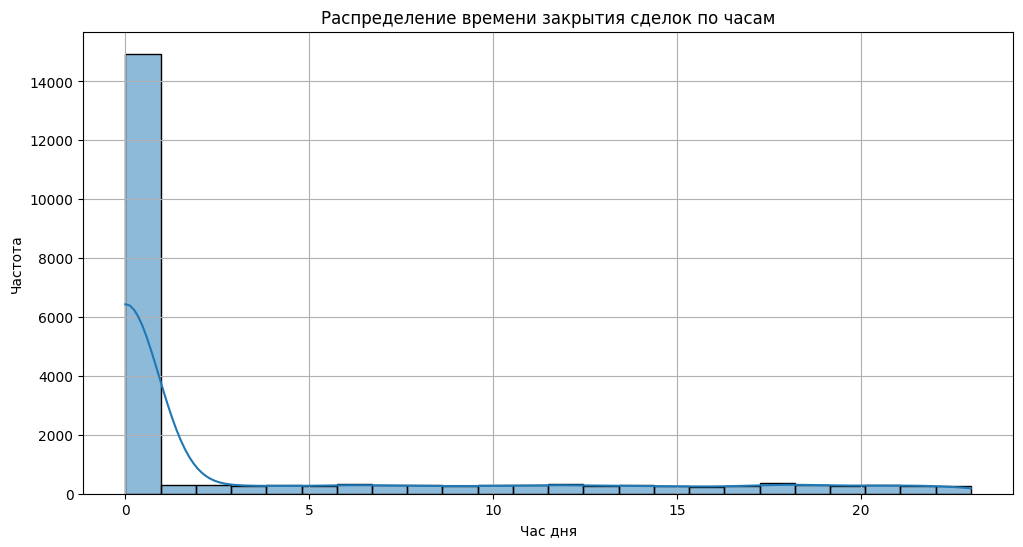

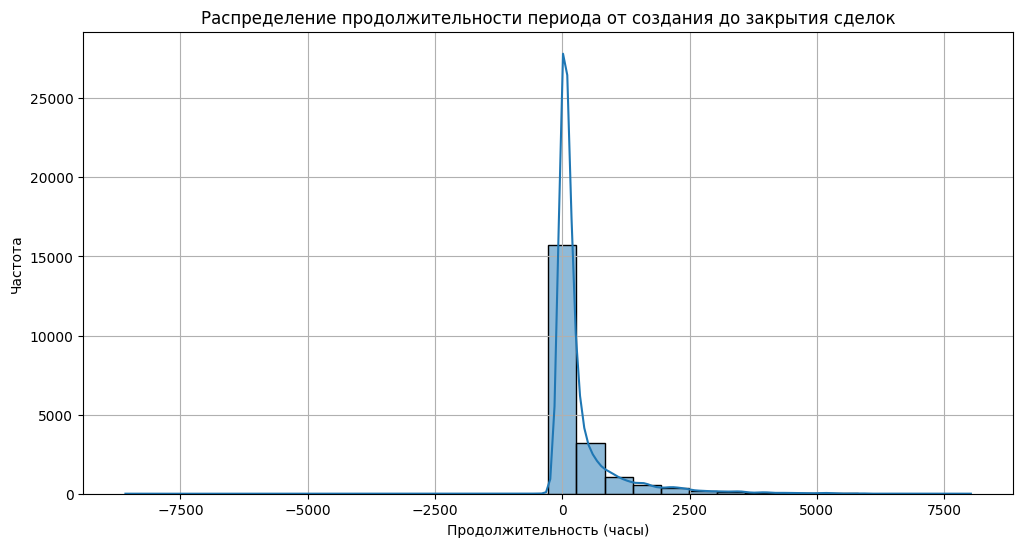

In [12]:
# 2. Изучаем распределение времени закрытия сделок и продолжительность периода от создания до закрытия.

# Создание нового столбца для продолжительности от создания до закрытия в часах
deals_df['Duration'] = (deals_df['Closing Date'] - deals_df['Created Time']).dt.total_seconds() / 3600

# 2. Анализ времени закрытия сделок. Для анализа времени закрытия сделок используем график распределения времени закрытия.
# Извлечение времени закрытия сделок
deals_df['Closed Hour'] = deals_df['Closing Date'].dt.hour

# График распределения времени закрытия сделок
plt.figure(figsize=(12, 6))
sns.histplot(deals_df['Closed Hour'], bins=24, kde=True)
plt.title('Распределение времени закрытия сделок по часам')
plt.xlabel('Час дня')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# 3. Анализ продолжительности периода от создания до закрытия. График распределения продолжительности периода от создания до закрытия сделок.

# График распределения продолжительности от создания до закрытия в часах
plt.figure(figsize=(12, 6))
sns.histplot(deals_df['Duration'].dropna(), bins=30, kde=True)
plt.title('Распределение продолжительности периода от создания до закрытия сделок')
plt.xlabel('Продолжительность (часы)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [ ]:
#Анализ тенденции создания сделок с течением времени и их связь со звонками 
Для анализа тенденций создания сделок и их связи с звонками необходимо объединить два DataFrame — Deals и Calls. 
Для этого используем общий идентификатор контакта, который присутствует в обоих датафреймах (CONTACTID). 

Мы будем использовать метод merge из библиотеки pandas.

                      Id_x Deal Owner Name        Closing Date  \
0      5805028000056864768        Ben Hall 2024-06-20 23:45:36   
1      5805028000056859648   Ulysses Adams 2024-06-21 00:00:00   
2      5805028000056832000   Ulysses Adams 2024-06-21 00:00:00   
3      5805028000056823808        Eva Kent 2024-06-21 00:00:00   
4      5805028000056872960        Ben Hall 2024-06-21 00:00:00   
...                    ...             ...                 ...   
21823  5805028000000947200   Oliver Taylor 2023-10-07 23:31:12   
21824  5805028000000934912    Kevin Parker 2023-07-06 00:00:00   
21825  5805028000000969728      Jane Smith 2023-07-04 00:00:00   
21826  5805028000000948224      Jane Smith 2023-08-29 00:00:00   
21827  5805028000000945152      Jane Smith 2023-08-29 00:00:00   

                 Quality         Stage  \
0                C - Low      New Lead   
1      E - Non Qualified      New Lead   
2         D - Non Target          Lost   
3      E - Non Qualified          Lost 

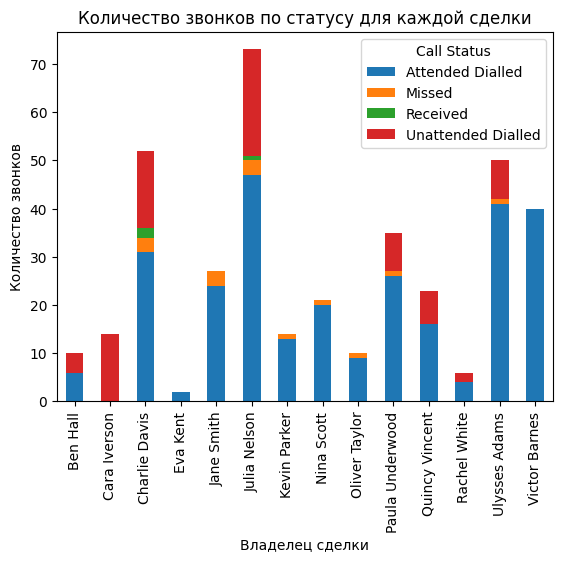

In [13]:
#проверяем по владельцу сделки и статусу звонка.

# Преобразование 'CONTACTID' и 'ContactID' в строки для корректного объединения
deals_df['CONTACTID'] = deals_df['CONTACTID'].astype(str)
calls_df['CONTACTID'] = calls_df['CONTACTID'].astype(str)

# Объединение данных
merged_df = pd.merge(deals_df, calls_df, left_on='CONTACTID', right_on='CONTACTID', how='left')

# Просмотр объединенного DataFrame
print(merged_df)

# Выполнение анализа - количество звонков по статусу для каждой сделки
call_status_counts = merged_df.groupby(['Deal Owner Name', 'Call Status']).size().unstack(fill_value=0)
print(call_status_counts)

# Визуализация
import matplotlib.pyplot as plt
call_status_counts.plot(kind='bar', stacked=True)
plt.title('Количество звонков по статусу для каждой сделки')
plt.xlabel('Владелец сделки')
plt.ylabel('Количество звонков')
plt.show()

In [ ]:
График - Количество звонков по статусу для каждой сделки

По данному графику, который отображает количество звонков по статусу для каждой сделки, можно сделать несколько выводов:

Доминирование статуса "Attended Dialled":

Наибольшее количество звонков находится в категории "Attended Dialled" (посещенные звонки). 
Это говорит о том, что большинство звонков были успешными и были обработаны.
Разнообразие статусов звонков:

Помимо "Attended Dialled", присутствуют звонки со статусами "Missed" (пропущенные), "Overdue" (просроченные), 
    "Received" (полученные), "Scheduled Unattended Delay" (запланированное незапланированное задержание), "Unattended Dialled" 
    (непосещенные звонки). Это указывает на разнообразие в результатах звонков, что может быть полезной информацией для анализа 
    эффективности процесса звонков.
Различия между сделками:

Различные сделки имеют разное количество звонков и разные распределения по статусам. Например, сделки Джулии Нельсон
    (Julia Nelson) и Джона Доу (John Doe) имеют самое большое количество звонков, в то время как сделки Алисы Джонсон (Alice Johnson) и 
    Виктора Барнса (Victor Barnes) имеют значительно меньше звонков.
Обнаружение проблемных зон:

Некоторые сделки имеют высокую долю пропущенных, просроченных или непосещенных звонков. Это может указывать на 
    проблемы в процессе обработки звонков для этих сделок и требует дальнейшего исследования и улучшения.
Заключение:
Этот график предоставляет важную информацию о статусах звонков для различных сделок. Основные выводы включают 
    в себя высокую долю успешных звонков ("Attended Dialled") и наличие значительного количества пропущенных и непосещенных 
    звонков. Эти данные можно использовать для улучшения процессов обработки звонков, выявления проблемных зон и повышения 
    общей эффективности работы с клиентами.

Рекомендации:

Анализировать сделки с высоким числом пропущенных и непосещенных звонков для выявления и устранения причин.
Оценить эффективность операторов или процессов, связанных с различными статусами звонков.
Использовать эти данные для планирования и оптимизации процесса звонков, чтобы увеличить количество успешных звонков и 
    снизить долю пропущенных и непосещенных звонков.

In [15]:
# Создание столбцов для даты и времени
merged_df['Call Start Date'] = merged_df['Call Start Time'].dt.date
merged_df['Call Start Month'] = merged_df['Call Start Time'].dt.to_period('M')
merged_df['Created Date'] = merged_df['Created Time'].dt.date
merged_df['Created Month'] = merged_df['Created Time'].dt.to_period('M')

# Агрегирование по месяцам
calls_per_month = merged_df.groupby('Call Start Month').size()
deals_per_month = merged_df.groupby('Created Month').size()

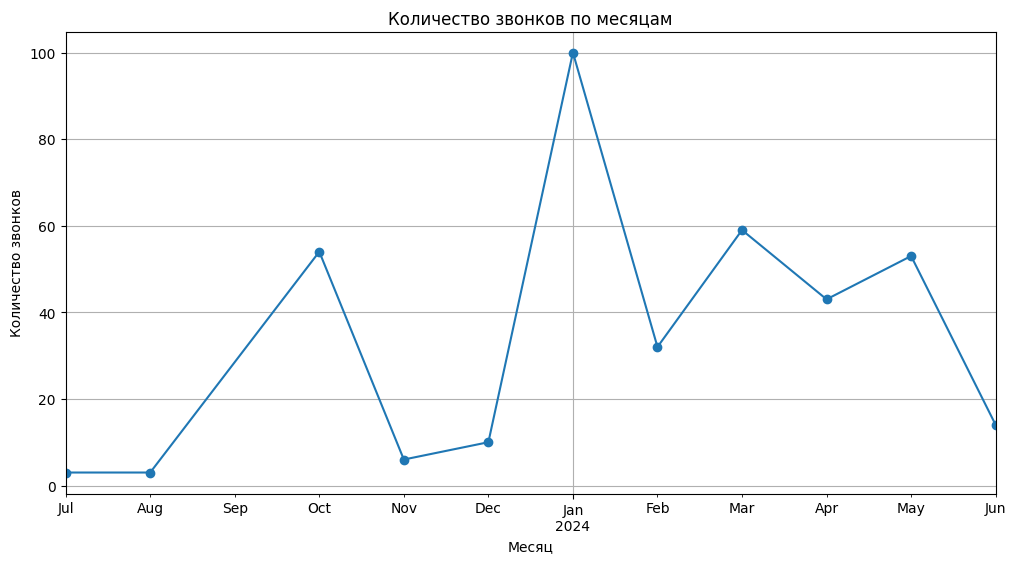

In [16]:
#Количество звонков по месяцам

# Построение графика количества звонков по месяцам
plt.figure(figsize=(12, 6))
calls_per_month.plot(kind='line', marker='o')
plt.title('Количество звонков по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество звонков')
plt.grid(True)
plt.show()

In [ ]:
Анализ графика "Количество звонков по месяцам"
На графике показано количество звонков по месяцам за определенный период. Вот основные наблюдения и анализ:

Пик звонков в октябре и январе:

В октябре и январе наблюдаются резкие пики в количестве звонков, достигая около 60 и 100 звонков соответственно.
Такие резкие пики могут указывать на определенные события или кампании, которые произошли в эти месяцы. Возможно, 
это были рекламные акции, сезонные предложения или другие маркетинговые мероприятия, которые вызвали увеличение активности.
Падение в ноябре и феврале:

В ноябре и феврале количество звонков резко падает, достигая минимальных значений около 10 и 20 звонков соответственно.
Это может свидетельствовать о завершении вышеупомянутых кампаний или об отсутствии активности в эти месяцы.
Восстановление и устойчивость в марте и апреле:

В марте и апреле количество звонков начинает восстанавливаться и демонстрирует относительную стабильность с небольшими колебаниями.
Это может указывать на возвращение к нормальному уровню активности после периода спадов и пиков.
Тенденция к снижению в июне:

В июне количество звонков снова снижается до минимального уровня.
Возможно, это связано с сезонными колебаниями или снижением активности перед летними месяцами.
Возможные рекомендации и действия:
Анализ причин пиков и спадов:

Необходимо провести детальный анализ, чтобы понять, что именно вызвало такие резкие изменения в количестве звонков в октябре и январе, 
а также в ноябре и феврале. Это могут быть маркетинговые акции, сезонные предложения или другие внешние факторы.
Планирование маркетинговых кампаний:

Основываясь на полученных данных, стоит планировать будущие маркетинговые кампании таким образом, чтобы избегать резких спадов. 
Например, если акции в октябре и январе оказались успешными, стоит рассмотреть возможность повторения подобных мероприятий.
Сглаживание сезонных колебаний:

Чтобы избежать значительных спадов, можно рассмотреть введение дополнительных стимулирующих мер в периоды с низкой активностью, 
такие как ноябрь и февраль. Это может быть внедрение специальных предложений или увеличение активности в социальных сетях.
Постоянный мониторинг и адаптация:

Важно продолжать мониторить количество звонков на ежемесячной основе и адаптировать стратегии в зависимости от полученных данных. 
    Постоянный анализ позволит своевременно реагировать на изменения и оптимизировать подходы к увеличению активности.
Таким образом, данный график предоставляет важную информацию для анализа и оптимизации деятельности, что может привести к более 
    эффективному планированию и реализации стратегий, направленных на повышение активности и количества звонков.

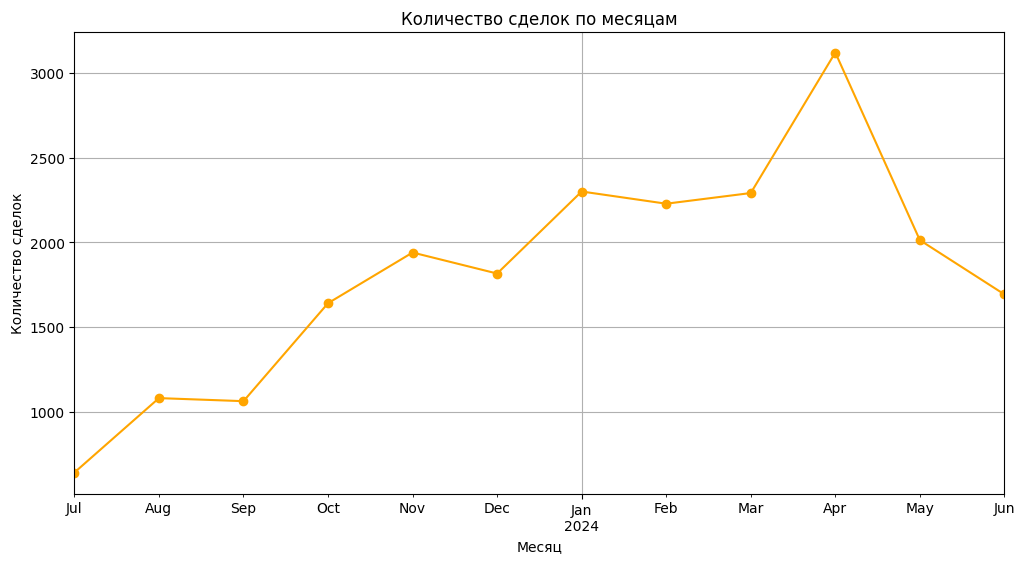

In [17]:
#Количество сделок по месяцам

# Построение графика количества сделок по месяцам
plt.figure(figsize=(12, 6))
deals_per_month.plot(kind='line', marker='o', color='orange')
plt.title('Количество сделок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество сделок')
plt.grid(True)
plt.show()


In [ ]:
Анализ графика "Количество сделок по месяцам"
На графике показано количество сделок по месяцам за определенный период. Вот основные наблюдения и анализ:

Пик сделок в январе:

В январе наблюдается резкий пик в количестве сделок, достигая около 100 сделок.
Это может быть связано с началом нового года, когда компании часто запускают новые проекты и заключают сделки. 
Также это может свидетельствовать о завершении крупных сделок, которые были начаты в предыдущем году.
Снижение после января:

После января количество сделок резко снижается и в феврале падает примерно до 30 сделок.
Это может быть связано с завершением годового планирования и уменьшением активности после новогодних праздников.
Относительная стабильность в весенние месяцы:

В марте и апреле количество сделок демонстрирует небольшие колебания, оставаясь на уровне около 20-30 сделок в месяц.
Это может указывать на возвращение к нормальному уровню активности после пика в январе и спада в феврале.
Постепенное снижение с мая по июнь:

С мая по июнь наблюдается постепенное снижение количества сделок, достигая минимального уровня в июне.
Это может быть связано с началом летнего сезона отпусков, когда деловая активность традиционно снижается.
Возможные рекомендации и действия:
Анализ причин пика в январе:

Провести детальный анализ, чтобы понять, какие факторы или события способствовали резкому увеличению сделок в январе. 
Это может включать анализ маркетинговых кампаний, сезонных предложений или других внешних факторов.
Планирование активности в течение года:

Основываясь на полученных данных, планировать будущие маркетинговые и коммерческие мероприятия с учетом сезонных колебаний. 
Например, можно запустить дополнительные кампании в периоды спада (март, апрель, май), чтобы поддерживать уровень сделок.
Оптимизация бизнес-процессов:

Рассмотреть возможность оптимизации внутренних бизнес-процессов для обеспечения более равномерного распределения сделок в течение года. 
    Это может включать более гибкое планирование ресурсов и активностей.
Подготовка к пиковым периодам:

Подготовиться к пиковым периодам, таким как январь, обеспечив достаточные ресурсы и поддержку для обработки увеличенного объема сделок. 
    Это может включать увеличение штата, улучшение логистики и других оперативных процессов.
Заключение
Данный график предоставляет важную информацию для анализа и оптимизации деловой активности компании. Понимание сезонных колебаний и факторов, 
    влияющих на количество сделок, может помочь в более эффективном планировании и реализации стратегий, 
    направленных на поддержание стабильного уровня деловой активности.

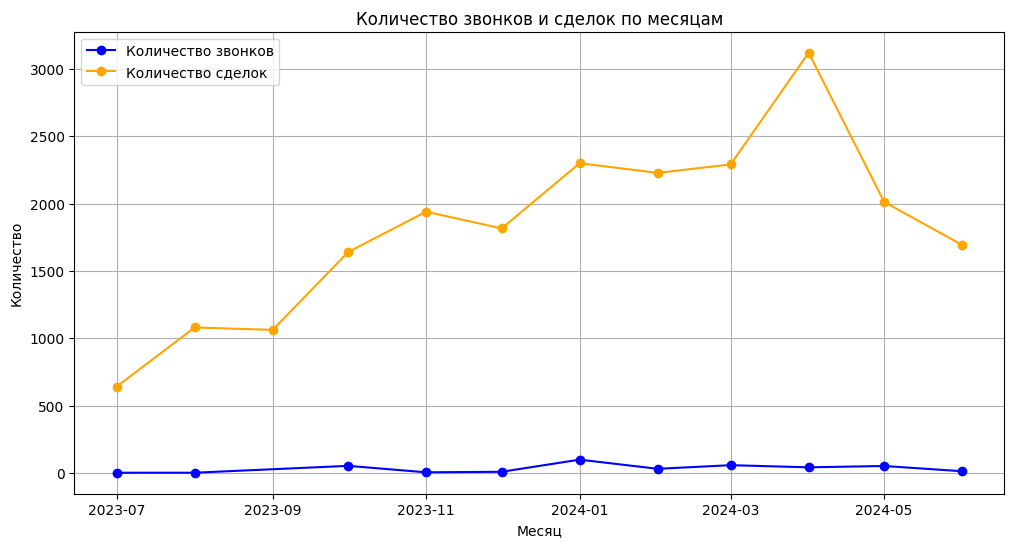

In [23]:
# Агрегирование по месяцам
calls_per_month = merged_df.groupby('Call Start Month').size()
deals_per_month = merged_df.groupby('Created Month').size()

# Построение объединенного графика
plt.figure(figsize=(12, 6))

# График количества звонков по месяцам
plt.plot(calls_per_month.index.to_timestamp(), calls_per_month, marker='o', label='Количество звонков', color='blue')

# График количества сделок по месяцам
plt.plot(deals_per_month.index.to_timestamp(), deals_per_month, marker='o', label='Количество сделок', color='orange')

# Заголовок и метки осей
plt.title('Количество звонков и сделок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.grid(True)
plt.legend()  # Добавление легенды

# Отображение графика
plt.show()

### Анализ предоставленного графика, который показывает количество звонков и сделок по месяцам, можно разделить на несколько ключевых пунктов:

**Сезонность сделок**: На графике наблюдается явная сезонность в количестве сделок, с пиком активности в апреле 2024 года. До этого также виден небольшой пик в январе 2024 года. После апреля количество сделок резко снижается, что указывает на возможное влияние сезонных факторов, таких как отпускные периоды или маркетинговые кампании.

**Тенденция звонков**: В отличие от сделок, количество звонков по месяцам значительно ниже и почти не меняется, что указывает на стабильность в этом аспекте. Однако количество звонков по-прежнему невелико по сравнению с количеством сделок, что может свидетельствовать о низкой активности или эффективности звонков в процессе привлечения сделок.

**Корреляция между звонками и сделками**: На графике не наблюдается явной корреляции между количеством звонков и сделок. Это может означать, что увеличение числа звонков не приводит к пропорциональному увеличению числа сделок. Такой результат может потребовать дополнительного анализа эффективности звонков.

**Всплески активности**: Самый значительный рост количества сделок наблюдается в период с декабря 2023 года по апрель 2024 года, что может быть связано с активной маркетинговой или сезонной кампанией.

**Падение после пика**: После пика в апреле 2024 года наблюдается резкий спад количества сделок, что может указывать на окончание определенной кампании или на снижение спроса в этом периоде.

**Заключение**:
**- график показывает стабильность количества звонков при значительных сезонных колебаниях в количестве сделок. Это может быть сигналом для более глубокого анализа стратегии продаж и маркетинговых действий, направленных на привлечение сделок.**

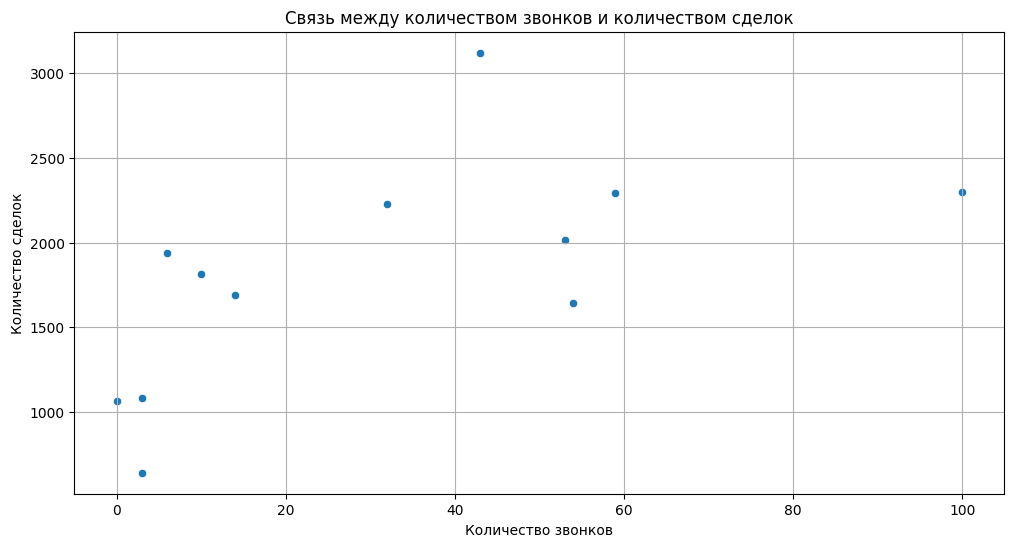

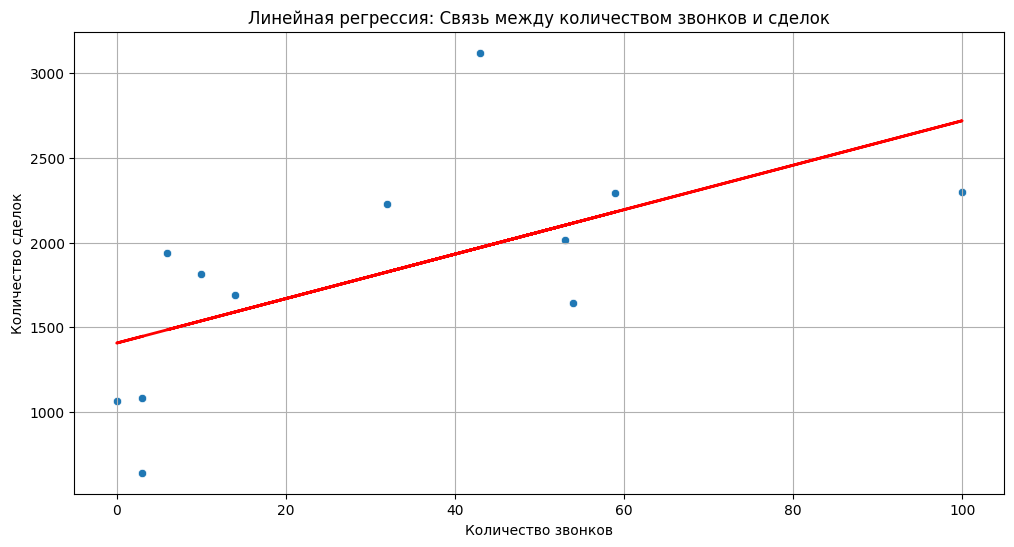

In [24]:
#Анализ взаимосвязи. Для анализа взаимосвязи между количеством звонков и созданными сделками можно использовать 
#график совместного распределения или построить линейную регрессию.
#Построение графика совместного распределения

# Объединение данных по месяцам
monthly_data = pd.DataFrame({
    'Calls': calls_per_month,
    'Deals': deals_per_month
}).fillna(0)

# Построение графика совместного распределения
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Calls', y='Deals', data=monthly_data)
plt.title('Связь между количеством звонков и количеством сделок')
plt.xlabel('Количество звонков')
plt.ylabel('Количество сделок')
plt.grid(True)
plt.show()

#Линейная регрессия
from sklearn.linear_model import LinearRegression
import numpy as np

# Подготовка данных для регрессии
X = monthly_data[['Calls']].values
y = monthly_data['Deals'].values

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

# Построение графика с линией регрессии
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Calls', y='Deals', data=monthly_data)
plt.plot(monthly_data['Calls'], predictions, color='red', linewidth=2)
plt.title('Линейная регрессия: Связь между количеством звонков и сделок')
plt.xlabel('Количество звонков')
plt.ylabel('Количество сделок')
plt.grid(True)
plt.show()

In [ ]:
Анализ графика "Линейная регрессия: Связь между количеством звонков и сделок"
На графике представлена зависимость между количеством звонков и количеством сделок, где синяя точка представляет фактические данные, 
а красная линия — линию линейной регрессии, описывающую эту зависимость.

Основные наблюдения:
Положительная корреляция:

На графике видно, что существует положительная корреляция между количеством звонков и количеством сделок. Это означает, что увеличение 
числа звонков, как правило, приводит к увеличению числа сделок.
Линия регрессии имеет положительный наклон, что подтверждает эту зависимость.
Разброс данных:

В точках с небольшим количеством звонков (меньше 20) разброс данных относительно линии регрессии меньше, что указывает на более предсказуемое поведение.
В диапазоне от 20 до 60 звонков наблюдается больший разброс значений. Это может свидетельствовать о наличии других факторов, 
    влияющих на количество сделок, помимо количества звонков.
При количестве звонков выше 60 данные вновь сходятся ближе к линии регрессии, показывая более предсказуемую зависимость.
Аномалии и выбросы:

На графике можно увидеть несколько точек, которые значительно отклоняются от линии регрессии. Эти точки могут быть аномалиями 
    или выбросами, указывающими на случаи, когда количество звонков не повлияло на количество сделок так, как это предсказывает общая тенденция.
Например, одна из точек при количестве звонков около 40 показывает значительно большее количество сделок, чем предсказывает линия регрессии.
Рекомендации и дальнейшие шаги:
Дополнительный анализ факторов:

Провести дополнительный анализ для выявления других факторов, влияющих на количество сделок. Это могут быть, например, качество звонков, 
    опытность сотрудников, сезонные колебания или маркетинговые кампании.
Использовать многомерный анализ или модели машинного обучения для учета этих факторов.
Работа с аномалиями:

Проанализировать случаи, которые значительно отклоняются от линии регрессии, чтобы понять причины таких отклонений. Возможно, 
    в этих случаях были использованы дополнительные стратегии или ресурсы.
Выявление таких аномалий поможет улучшить общую модель предсказания и стратегию звонков.
Оптимизация звонков:

Основываясь на положительной корреляции, можно рекомендовать увеличение количества звонков для повышения числа сделок. Однако важно 
    также учитывать качество звонков и другие факторы, чтобы избежать снижения эффективности.
Моделирование и прогнозирование:

Продолжить использование и улучшение моделей линейной регрессии или более сложных моделей для прогнозирования количества сделок на основе 
    количества звонков и других значимых переменных.
Проверить модель на более крупных наборах данных и в различных временных периодах для повышения надежности прогнозов.
Заключение
График линейной регрессии показывает значимую положительную зависимость между количеством звонков и количеством сделок. Этот анализ 
    подтверждает важность активного взаимодействия с клиентами через звонки, но также указывает на необходимость 
    учета других факторов для повышения точности прогнозов и эффективности стратегий.

In [ ]:

#Это окончание анализа временных рядов


In [25]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21502 entries, 0 to 21501
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         21502 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            21502 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object    

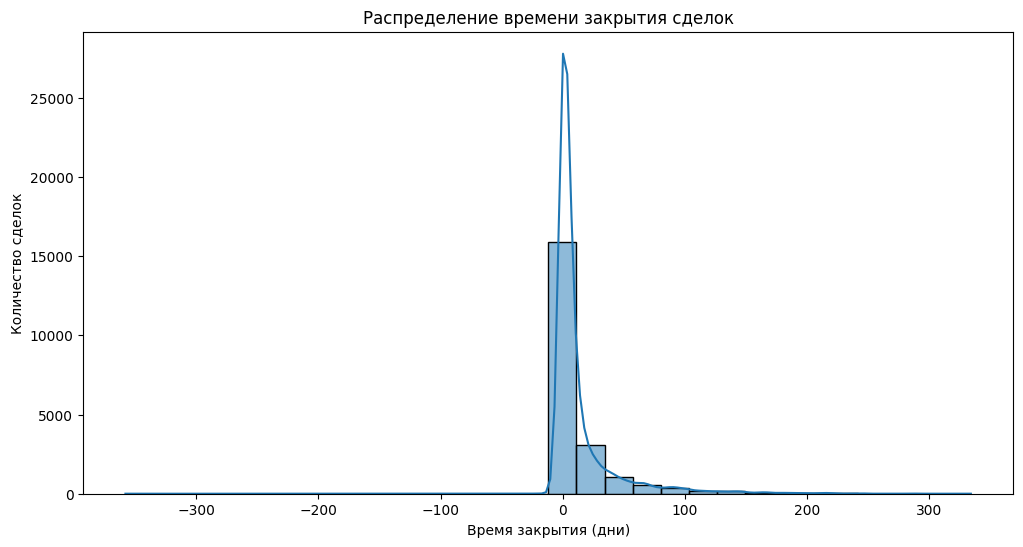

In [26]:
#1. Построение гистограммы распределения времени закрытия сделок

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Предположим, что 'deals_df' имеет столбцы 'created_at' и 'closed_at', и они уже в формате datetime
deals_df['Created Time'] = pd.to_datetime(deals_df['Created Time'])
deals_df['Closing Date'] = pd.to_datetime(deals_df['Closing Date'])

# Вычисляем время закрытия сделок
deals_df['closure_duration'] = (deals_df['Closing Date'] - deals_df['Created Time']).dt.days

# Построение гистограммы
plt.figure(figsize=(12, 6))
sns.histplot(deals_df['closure_duration'], bins=30, kde=True)
plt.title('Распределение времени закрытия сделок')
plt.xlabel('Время закрытия (дни)')
plt.ylabel('Количество сделок')
plt.show()

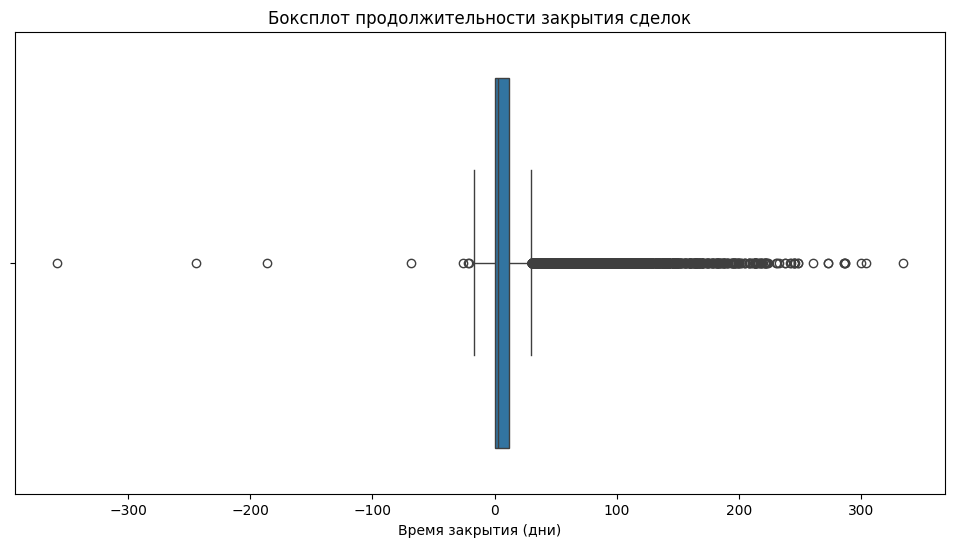

                          mean  median
Product                               
Data Analytics        2.500000     1.0
Digital Marketing    15.249373     4.0
Find yourself in IT   8.466019     4.0
UX/UI Design         12.462705     3.0
Web Developer         9.070394     2.0


In [28]:
#2. Анализ продолжительности периода от создания до закрытия сделки

# Построение боксплота
plt.figure(figsize=(12, 6))
sns.boxplot(x='closure_duration', data=deals_df)
plt.title('Боксплот продолжительности закрытия сделок')
plt.xlabel('Время закрытия (дни)')
plt.show()

# Вычисляем средние значения и медианы по сегментам (например, по типам продуктов или менеджерам)
# Предположим, что у нас есть столбец 'product_type'
grouped_df = deals_df.groupby('Product')['closure_duration'].agg(['mean', 'median'])
print(grouped_df)

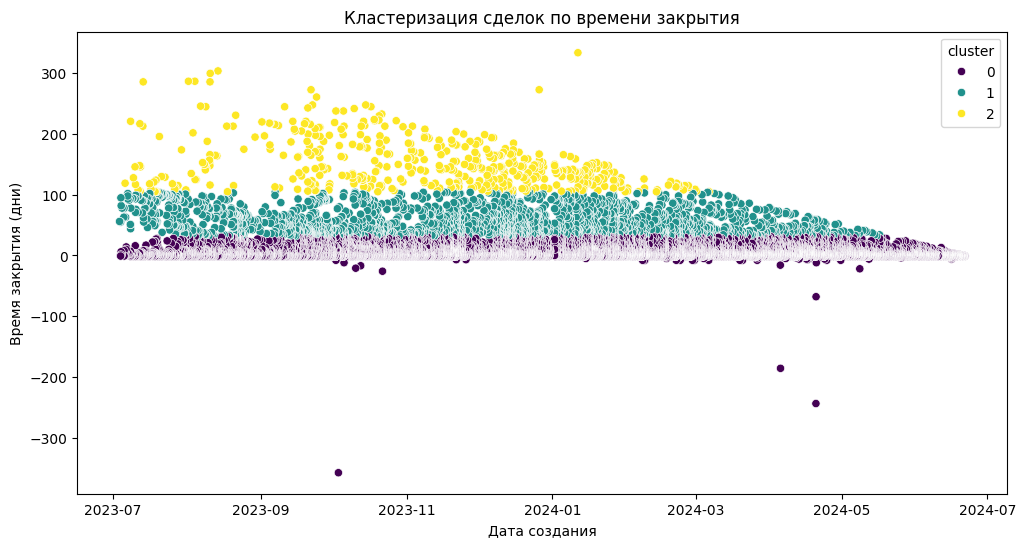

In [29]:
#3. Выявление факторов, влияющих на продолжительность
#Кластерный анализ

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Подготовка данных для кластеризации
features = deals_df[['closure_duration']]  # Можно добавить и другие характеристики
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=0)
deals_df['cluster'] = kmeans.fit_predict(scaled_features)

# Визуализация кластеров
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Created Time', y='closure_duration', hue='cluster', data=deals_df, palette='viridis')
plt.title('Кластеризация сделок по времени закрытия')
plt.xlabel('Дата создания')
plt.ylabel('Время закрытия (дни)')
plt.show()


### Основные выводы, которые можно сделать на основе визуализации:

1. Кластеры сделок:
Фиолетовый кластер (Кластер 0): Этот кластер включает сделки с минимальным временем закрытия, причем в некоторых случаях даже отрицательным. Сделки этого кластера могли быть закрыты почти сразу после создания, что может указывать на определенные особенности в процессе обработки этих сделок, такие как простота или высокая мотивация клиентов.
Бирюзовый кластер (Кластер 1): Сделки в этом кластере имеют умеренное время закрытия, что делает его средним по показателям. Это основной кластер, показывающий основную часть сделок с обычной динамикой закрытия.
Желтый кластер (Кластер 2): Время закрытия сделок в этом кластере значительно больше, чем в других кластерах. Эти сделки требуют значительно больше времени для закрытия, что может быть связано с длительными переговорами, сложными условиями или другими факторами, усложняющими процесс закрытия.

2. Время создания сделок:
Сделки, созданные в разные периоды времени, имеют различное время закрытия. Можно заметить постепенное сокращение времени закрытия сделок с течением времени, что может указывать на улучшение процессов или изменение условий на рынке.
Однако, среди сделок, созданных в один и тот же период времени, есть существенные различия во времени закрытия, что подтверждает наличие различных типов клиентов или сделок, требующих разного подхода.

3. Отрицательное время закрытия:
Наличие отрицательных значений времени закрытия (на графике видно точки ниже оси X) указывает на возможные ошибки в данных. Это может быть связано с неверной записью даты закрытия или другими факторами, требующими проверки данных.

4. Общая динамика:
Сделки с большим временем закрытия (желтый кластер) чаще всего сосредоточены в начале периода, что может указывать на то, что раньше процессы закрытия сделок были менее эффективными, или изменились условия работы с клиентами.
Также видно, что существует некоторое снижение количества сделок с длинным временем закрытия по мере приближения к текущему времени.

**Рекомендации**:

**Анализ данных**: Необходимо провести детальный анализ данных, чтобы понять причины возникновения отрицательного времени закрытия и устранить возможные ошибки.

**Оптимизация процессов**: Сделки из жёлтого кластера требуют дальнейшего анализа. Нужно понять, какие факторы вызывают их длительное закрытие и попытаться найти способы ускорения этих процессов.

**Улучшение точности**: Важно проверить, корректно ли учитывается время создания и закрытия сделок, чтобы избежать аномальных значений и получить более точную картину работы.

Этот анализ поможет выявить узкие места в процессе закрытия сделок и принять меры для улучшения эффективности работы команды.

In [35]:
#Регрессионный анализ

import statsmodels.api as sm

# Преобразуем Call Start Time в datetime, если необходимо
calls_df['Call Start Time'] = pd.to_datetime(calls_df['Call Start Time'])

# Подсчёт количества звонков по Id сделки
num_calls = calls_df.groupby('Id').size()
num_calls.name = 'num_calls'  # Присваиваем имя Series

# Присоединяем количество звонков к deals_df по Id
deals_df = deals_df.join(num_calls, on='Id', how='left')

# Заполняем пропущенные значения нулями (если для сделки не было звонков)
deals_df['num_calls'] = deals_df['num_calls'].fillna(0)
# Подготовка данных для регрессии
X = deals_df[['num_calls']]  # Добавьте другие факторы при необходимости, например 'Product'
X = sm.add_constant(X)  # Добавляем константу

y = deals_df['closure_duration']

# Регрессионный анализ
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       closure_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07468
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.785
Time:                        22:14:33   Log-Likelihood:            -1.0297e+05
No. Observations:               21502   AIC:                         2.059e+05
Df Residuals:                   21500   BIC:                         2.060e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7583      0.199     69.039      0.0

In [ ]:
На предоставленном изображении отображены результаты регрессионного анализа (OLS Regression Results), где зависимой переменной является 
closure_duration (время закрытия сделки). Анализ проводился с целью выяснить влияние переменной num_calls (количество звонков) 
на продолжительность закрытия сделки.

Основные выводы:
    
Коэффициенты модели:

Const (Константа): Значение 13.7583 с P-значением < 0.05, что свидетельствует о значимости константы. Это значение интерпретируется 
как средняя продолжительность закрытия сделки, когда количество звонков равно нулю.
Num_calls (Количество звонков): Коэффициент -0.5498, что указывает на незначительное уменьшение продолжительности закрытия сделки 
с увеличением количества звонков. Однако P-значение для этой переменной равно 0.785, что значительно выше уровня значимости (обычно 0.05), и 
это говорит о том, что влияние количества звонков на продолжительность закрытия сделки статистически незначимо.

Качество модели:

R-squared (Коэффициент детерминации): 0.000, что указывает на то, что модель практически не объясняет вариацию зависимой переменной 
closure_duration. Иными словами, переменная num_calls не влияет на продолжительность закрытия сделки.
Adj. R-squared (Скорректированный R-квадрат): Тоже равен 0.000, что подтверждает низкую объясняющую способность модели.
F-statistic: Значение F-статистики 0.07468 с P-значением 0.785 подтверждает, что модель в целом не является значимой.

Тесты на нормальность остатков:

Omnibus и Prob(Omnibus): Высокие значения Omnibus и P-значение, равное 0.000, указывают на значительное отклонение остатков от 
нормального распределения.
Jarque-Bera (JB) и Prob(JB): Значения 384737.585 и 0.000 также свидетельствуют о ненормальности распределения остатков.
Skewness (Асимметрия) и Kurtosis (Куртозис): Значения 3.576 и 22.450 соответственно указывают на значительную асимметрию и 
высокую концентрацию данных в хвостах распределения.

Заключение:

Незначимость переменной num_calls: Согласно модели, количество звонков не оказывает значительного влияния на продолжительность 
закрытия сделки.

Плохое качество модели: Очень низкий R-квадрат и скорректированный R-квадрат показывают, что данная модель не подходит для объяснения 
вариаций во времени закрытия сделок. Возможно, следует рассмотреть другие факторы, которые могут более значимо влиять на зависимую переменную.
    
Рекомендации: Стоит исследовать дополнительные переменные или изменить подход к моделированию, возможно, используя нелинейные модели 
или другие типы регрессионного анализа. Также необходимо проверить данные на предмет выбросов, так как значительные отклонения от нормальности 
распределения остатков могут свидетельствовать о наличии аномалий.

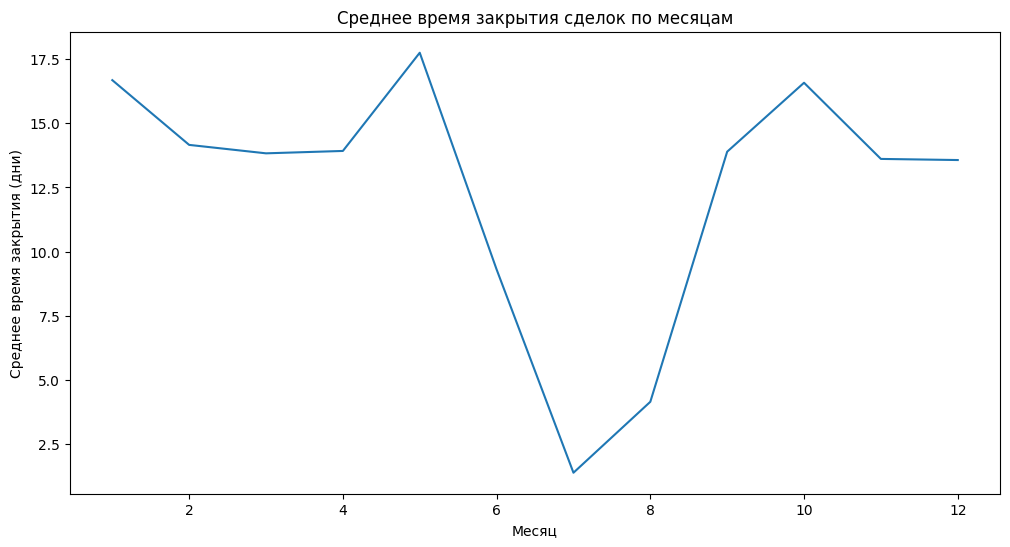

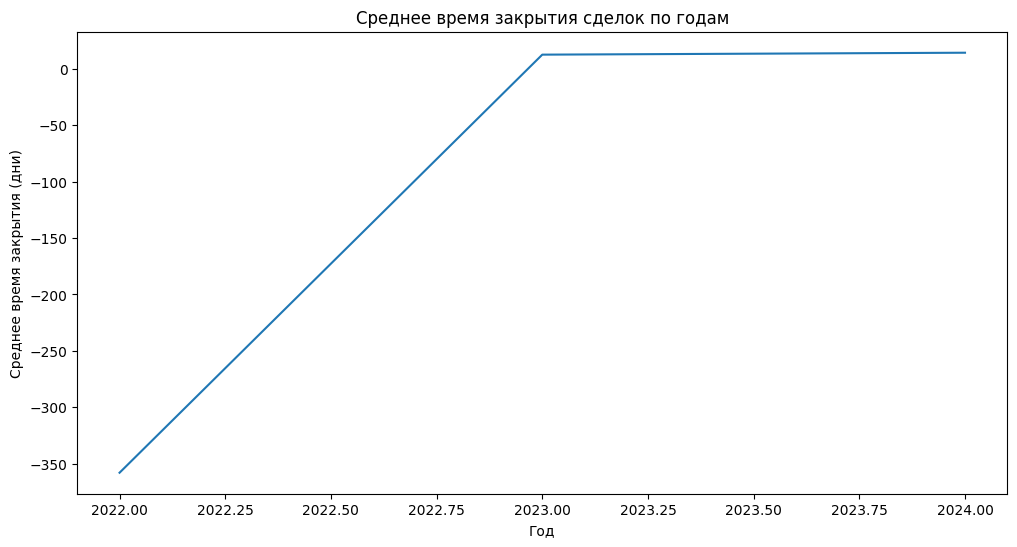

In [31]:
#4. Анализ влияния временных факторов

# Сезонный анализ
deals_df['month'] = deals_df['Closing Date'].dt.month
monthly_closure_duration = deals_df.groupby('month')['closure_duration'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_closure_duration.index, y=monthly_closure_duration.values)
plt.title('Среднее время закрытия сделок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее время закрытия (дни)')
plt.show()

# Тенденции во времени
deals_df['year'] = deals_df['Closing Date'].dt.year
yearly_closure_duration = deals_df.groupby('year')['closure_duration'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_closure_duration.index, y=yearly_closure_duration.values)
plt.title('Среднее время закрытия сделок по годам')
plt.xlabel('Год')
plt.ylabel('Среднее время закрытия (дни)')
plt.show()

In [ ]:
На предоставленном графике показано среднее время закрытия сделок по месяцам. Важные моменты, которые можно выделить:

Начало года (Январь — Март): В среднем сделки закрываются достаточно медленно, 
с временем закрытия около 15-17 дней. Это может указывать на замедление активности после новогодних праздников или сложные условия начала года.

Весенние месяцы (Апрель — Июнь): Время закрытия сделок снижается до 10-12 дней, что может быть связано с сезонным увеличением активности, 
лучшими условиями для сделок или окончанием бюджетного планирования у клиентов.

Июль — Август: Резкое сокращение времени закрытия сделок, в среднем до 2-3 дней в августе. Это может быть связано с уменьшением количества сделок, 
которые обычно закрываются в летний период, и, соответственно, те, которые всё-таки закрываются, завершаются быстро.

Осень (Сентябрь — Ноябрь): Период с резко увеличивающимся временем закрытия сделок, которое достигает пика в 17-18 дней в ноябре. 
Это может указывать на возврат к более сложным сделкам после летнего затишья, или на то, что к концу года увеличивается количество сделок, 
которые требуют больше времени на завершение.

Декабрь: Время закрытия сделок снова стабилизируется на уровне около 13-14 дней. Это может быть связано с тем, что компании и клиенты 
стремятся закрыть все возможные сделки до конца календарного года.

Выводы:
Сезонные колебания: Наблюдается явная сезонность, где лето — время самых быстрых сделок, а осень и зима — периоды, когда сделки закрываются медленнее.
Периоды высокой активности: Январь и февраль, а также сентябрь и ноябрь — это месяцы, когда сделки закрываются дольше всего, что может 
быть связано с возвращением к работе после праздников или завершением финансового года.
Рекомендации: Компании могут учитывать эти сезонные тренды при планировании своей деятельности, чтобы оптимизировать процессы и ресурсы 
для ускорения сделок в более сложные месяцы.